In [2]:
 from google.colab import drive
 drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 45.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [5]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning import LightningDataModule

class FraudDataModule(LightningDataModule):
    def __init__(self, data_dir="/content/drive/MyDrive/data/processed", batch_size=128):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

    def setup(self, stage=None):
        # Load data
        X_train = pd.read_csv(f"{self.data_dir}/X_train.csv").values
        y_train = pd.read_csv(f"{self.data_dir}/y_train.csv").values.ravel()
        X_test = pd.read_csv(f"{self.data_dir}/X_test.csv").values
        y_test = pd.read_csv(f"{self.data_dir}/y_test.csv").values.ravel()

        # Convert to tensors
        self.train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                           torch.tensor(y_train, dtype=torch.float32))
        self.test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                          torch.tensor(y_test, dtype=torch.float32))

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_lightning import LightningModule
from torchmetrics.classification import BinaryAUROC, BinaryAccuracy, BinaryPrecision, BinaryRecall

class FraudModel(LightningModule):
    def __init__(self, input_dim=29, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.auroc = BinaryAUROC()
        self.accuracy = BinaryAccuracy()
        self.precision = BinaryPrecision()
        self.recall = BinaryRecall()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).squeeze()
        loss = self.loss_fn(logits, y)
        preds = torch.sigmoid(logits)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_auroc", self.auroc(preds, y.int()), prog_bar=True)
        self.log("train_acc", self.accuracy(preds, y.int()), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x).squeeze()
        loss = self.loss_fn(logits, y)
        preds = torch.sigmoid(logits)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_auroc", self.auroc(preds, y.int()), prog_bar=True)
        self.log("val_acc", self.accuracy(preds, y.int()), prog_bar=True)
        self.log("val_precision", self.precision(preds, y.int()), prog_bar=True)
        self.log("val_recall", self.recall(preds, y.int()), prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | Sequential        | 4.0 K  | train
1 | loss_fn   | BCEWithLogitsLoss | 0      | train
2 | auroc     | BinaryAUROC       | 0      | train
3 | accuracy  | BinaryAccuracy    | 0      | train
4 | precision | BinaryPrecision   | 0      | train
5 | recall    | BinaryRecall      | 0      | train
--------------------------------------------------------
4.0 K     Trainable params
0         Non-trainable params
4.0 K     Total params
0.016     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/di

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/di

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/di

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/di


[INFO] Classification Report:
              precision    recall  f1-score   support

   Not Fraud       1.00      0.99      1.00     56864
       Fraud       0.21      0.88      0.34        98

    accuracy                           0.99     56962
   macro avg       0.61      0.94      0.67     56962
weighted avg       1.00      0.99      1.00     56962

[INFO] Confusion matrix saved to /content/drive/MyDrive/data/confusion_matrix.png


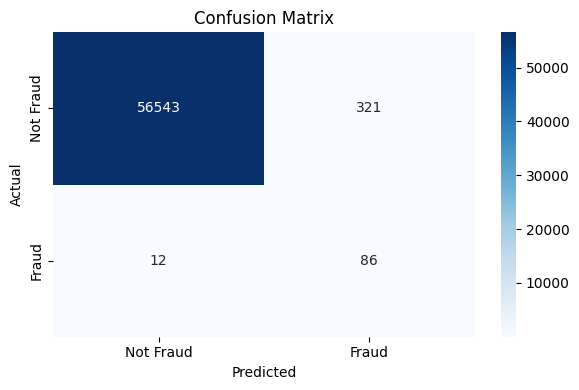

In [9]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torch
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, save_path="/content/drive/MyDrive/data/confusion_matrix.png"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(save_path)
    print(f"[INFO] Confusion matrix saved to {save_path}")

def test_model(model, datamodule):
    datamodule.setup()
    test_loader = datamodule.val_dataloader()
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in test_loader:
            logits = model(x).squeeze()
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).int()
            y_true.extend(y.numpy())
            y_pred.extend(preds.numpy())

    print("\n[INFO] Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["Not Fraud", "Fraud"]))
    plot_confusion_matrix(y_true, y_pred)

if __name__ == "__main__":
    datamodule = FraudDataModule(data_dir="/content/drive/MyDrive/data/processed", batch_size=256)
    model = FraudModel(input_dim=29)

    logger = CSVLogger("logs", name="fraud_detection")

    checkpoint_cb = ModelCheckpoint(
        monitor="val_auroc",
        mode="max",
        save_top_k=1,
        filename="best-checkpoint",
        dirpath="checkpoints/"
    )

    early_stop_cb = EarlyStopping(
        monitor="val_auroc",
        patience=3,
        mode="max",
        verbose=True
    )

    trainer = Trainer(
        max_epochs=10,
        logger=logger,
        callbacks=[checkpoint_cb, early_stop_cb],
        accelerator="auto",
        log_every_n_steps=1
    )

    trainer.fit(model, datamodule)

    # Load best model for testing
    best_model = FraudModel.load_from_checkpoint(checkpoint_cb.best_model_path)
    test_model(best_model, datamodule)